In [1]:
import torch 
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy, Precision, Recall, F1Score
from utils import retrieve_training_params, retrieve_setup

/home/admin/miniconda3/envs/oml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_metrics(num_classes, device):
    accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    precision = Precision(task="multiclass", num_classes=num_classes).to(device)
    recall = Recall(task="multiclass", num_classes=num_classes).to(device)
    f1 = F1Score(task="multiclass", num_classes=num_classes).to(device)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

def compute_metrics(metric_path, metrics, y_pred, y_true, tb_writer, n_iter):
    scores = {}
    for metric_name, metric in metrics.items():
        score = metric(y_pred, y_true)
        # print(f"{metric_name}: {score}")
        tb_writer.add_scalar(f"{metric_path}/{metric_name}", score, n_iter)
        scores[metric_name] = score
    return scores
    

def training_loop(model, dataset, scheduler, optimizer, loss_fn, n_epochs=1, batch_size=32,
                train_strategy=("", 1), test_strategy=("", 1), scheduler_strategy="iter", 
                tensorboard_path="./tensorboard", device=torch.device("cpu")):

    # data loader
    train_loader = DataLoader(dataset["train"], batch_size, shuffle=True) 
    eval_loader = DataLoader(dataset["test"], batch_size, shuffle=True) 

    # scheduler
    scheduler_name, scheduler = scheduler
    
    # tensorboard
    tb_writer = SummaryWriter(tensorboard_path)
    num_classes = len(dataset["train"].classes)
    metrics = get_metrics(num_classes, device)
    metric_tr_path = f"{train_loader.dataset.root.split('/')[-1]}/train"
    metric_te_path = f"{eval_loader.dataset.root.split('/')[-1]}/test"
    train_log = train_strategy[1] if train_strategy[0] == "iter" else train_strategy[1] * len(train_loader) + (train_loader.batch_size-1)
    eval_log = test_strategy[1] if test_strategy[0] == "iter" else test_strategy[1] * len(train_loader) + (train_loader.batch_size-1)

    # storage
    losses = []
    lr_history = []
    
    # Training loop
    model.to(device)
    for epoch in range(n_epochs):
        for tr_iter, (X_tr_batch, y_tr_batch) in enumerate(train_loader):
            X_tr_batch, y_tr_batch = X_tr_batch.to(device), y_tr_batch.to(device)

            model.train()
            optimizer.zero_grad()
            output = model(X_tr_batch)
            loss = loss_fn(output, y_tr_batch)
            loss.backward()
            optimizer.step()
            losses.append(loss.item()) 

            iter = epoch * len(train_loader) + tr_iter

            tb_writer.add_scalar(f"{metric_tr_path}/lr", scheduler.get_last_lr()[0], iter)
            
            if iter % train_log == 0:
                # print("train log metrics")
                tb_writer.add_scalar(f"{metric_tr_path}/loss", loss, iter)
                _, y_pred = torch.max(output, 1)
                compute_metrics(metric_tr_path, metrics, y_pred, y_tr_batch, tb_writer, iter)

            
            if iter % eval_log == 0:
                # print("test log metrics")
                model.eval()
                with torch.no_grad():
                    all_outputs = []
                    all_predictions = []
                    all_targets = []
                    for te_iter, (X_te_batch, y_te_batch) in enumerate(eval_loader):
                        X_te_batch, y_te_batch = X_te_batch.to(device), y_te_batch.to(device)

                        output = model(X_te_batch)
                        _, y_pred = torch.max(output, 1)

                        all_outputs.append(output)
                        all_predictions.append(y_pred)
                        all_targets.append(y_te_batch)
                        break
                    
                    all_outputs = torch.cat(all_outputs, dim=0)
                    all_predictions = torch.cat(all_predictions, dim=0)
                    all_targets = torch.cat(all_targets, dim=0)

                    loss = loss_fn(all_outputs, all_targets).item()
                    tb_writer.add_scalar(f"{metric_te_path}/loss", loss, iter)
                    compute_metrics(metric_te_path, metrics, all_predictions, all_targets, tb_writer, iter)

                    #tb_writer.flush()
                    #tb_writer.close()
                    #return None, None

            #update scheduler
            #if scheduler_strategy == "iter":
                # scheduler.step()

        #if scheduler_strategy == "epoch":
        # scheduler.step()

    losses = np.array(losses)

    tb_writer.flush()
    tb_writer.close()
    return model, losses

In [3]:
# Download model and dataset
model, dataset = retrieve_setup("MobileNetV3Small", "CIFAR10")
dataset_name = dataset["train"].root.split("/")[-1]

# Load all training parameters
optimizer, lr_schedulers, loss_fn, n_epochs, batch_size = retrieve_training_params(model, dataset_name)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Training
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_trained, losses = training_loop(
  model, 
  dataset, 
  lr_schedulers[0], 
  optimizer, 
  loss_fn, 
  n_epochs, 
  batch_size, 
  train_strategy=("iter", 2),
  test_strategy=("iter", 2),
  scheduler_strategy="iter", 
  tensorboard_path=f"./tensorboard/{dataset_name}_{lr_schedulers[0][0]}",
  device=device
)

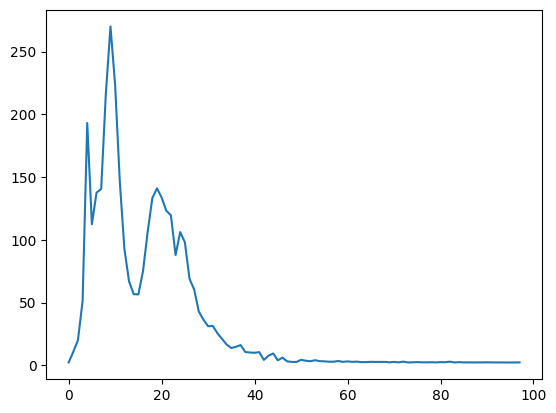

In [5]:
import numpy as np 

plt.plot(losses)
plt.show()